# Clustering

In [62]:
from kagglehub import dataset_download
from pathlib import Path

import pandas as pd 
import numpy as np

from matplotlib import pyplot as plt

from sklearn.preprocessing import FunctionTransformer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, davies_bouldin_score

import pickle

In [14]:
FASHION_MNIST_HANDLE = 'zalando-research/fashionmnist'

data_location = dataset_download(FASHION_MNIST_HANDLE)
# data_location = '~/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4'

kaggle_data_forlder = Path(data_location)
train_data_filename = 'fashion-mnist_train.csv'

df = pd.read_csv(kaggle_data_forlder / train_data_filename)

X_train, y_train = df.drop(columns='label'), df['label']

custom_normalizer = FunctionTransformer(func=(lambda x: x / 255), inverse_func=(lambda x: (x*255).astype(int)))

X_scaled = custom_normalizer.fit_transform(X_train)

### Useful tools

In [57]:
DATA_FOLDER = Path('model_selection/data')

In [69]:
def model_evaluate(model, dim_reduction_strat=None, n_components=None): 

    if dim_reduction_strat is None : 
        X = X_scaled
    else : 
        data_path = DATA_FOLDER / f'X_{dim_reduction_strat}_{n_components}.csv'
        X = pd.read_csv(data_path)

    model.fit(X)
    
    scores = {
        'adjusted_rand_score': adjusted_rand_score(model.labels_, y_train), 
        'adjusted_mutual_info_score': float(adjusted_mutual_info_score(model.labels_, y_train))
    }

    return scores


## k-means
As a first attempt let’s try the traditional approach: K-Means. In this case we can solve one of the hard problems for K-Means clustering – choosing the right k value, giving the number of clusters we are looking for. In this case we know the answer is exactly 10.

In [113]:
k_means_scores = []

### Original Data

In [ ]:
k_means_scores.append({
    'dimension_reduction': None,
    'n_components': None,
    **model_evaluate(KMeans(n_clusters=10, random_state=42))
})

[{'dimension_reduction': None,
  'n_components': None,
  'adjusted_rand_score': 0.4047006500809036,
  'adjusted_mutual_info_score': 0.5420462944267948}]

### PCA Transformed Data

In [118]:
k_means_scores += [
    {
        'dimension_reduction': 'pca',
        'n_components': 10,
        **model_evaluate(KMeans(n_clusters=10, random_state=42), 'pca', 10) 
    },
    {
        'dimension_reduction': 'pca',
        'n_components': 20,
        **model_evaluate(KMeans(n_clusters=10, random_state=42), 'pca', 20) 
    }, 
    {
        'dimension_reduction': 'pca',
        'n_components': 80,
        **model_evaluate(KMeans(n_clusters=10, random_state=42), 'pca', 80) 
    }, 
]

,dimension_reduction,n_components,adjusted_rand_score,adjusted_mutual_info_score
0,None,NaN,0.404701,0.542046
1,pca,10.0,0.338712,0.488058
2,pca,20.0,0.347294,0.507024
3,pca,80.0,0.390737,0.523687


### NMF Transformed Data

In [119]:
k_means_scores += [
    {
        'dimension_reduction': 'nmf',
        'n_components': 10,
        **model_evaluate(KMeans(n_clusters=10, random_state=42), 'nmf', 10) 
    },
    {
        'dimension_reduction': 'nmf',
        'n_components': 20,
        **model_evaluate(KMeans(n_clusters=10, random_state=42), 'nmf', 20) 
    }, 
    {
        'dimension_reduction': 'nmf',
        'n_components': 80,
        **model_evaluate(KMeans(n_clusters=10, random_state=42), 'nmf', 80) 
    }, 
]

,dimension_reduction,n_components,adjusted_rand_score,adjusted_mutual_info_score
0,None,NaN,0.404701,0.542046
1,pca,10.0,0.338712,0.488058
2,pca,20.0,0.347294,0.507024
3,pca,80.0,0.390737,0.523687
4,nmf,10.0,0.232076,0.434490
5,nmf,20.0,0.256232,0.406255
6,nmf,80.0,0.209876,0.363655


### UMAP Transformed Data

In [120]:
k_means_scores += [
    {
        'dimension_reduction': 'umap',
        'n_components': 10,
        **model_evaluate(KMeans(n_clusters=10, random_state=42), 'umap', 10) 
    },
    {
        'dimension_reduction': 'umap',
        'n_components': 20,
        **model_evaluate(KMeans(n_clusters=10, random_state=42), 'umap', 20) 
    }, 
    {
        'dimension_reduction': 'umap',
        'n_components': 80,
        **model_evaluate(KMeans(n_clusters=10, random_state=42), 'umap', 80) 
    }, 
]

,dimension_reduction,n_components,adjusted_rand_score,adjusted_mutual_info_score
0,None,NaN,0.404701,0.542046
1,pca,10.0,0.338712,0.488058
2,pca,20.0,0.347294,0.507024
3,pca,80.0,0.390737,0.523687
4,nmf,10.0,0.232076,0.434490
5,nmf,20.0,0.256232,0.406255
6,nmf,80.0,0.209876,0.363655
7,umap,10.0,0.456125,0.622112
8,umap,20.0,0.454139,0.633707
9,umap,80.0,0.454360,0.633524


In [ ]:
pd.DataFrame(k_means_scores)

Observations: 
- The clustering scores are higher when using the original dataset compared to data transformed by PCA or NMF. However, clustering with the original data requires significantly more time to execute.
- Clustering with UMAP-transformed data delivers superior performance compared to other transformations and original dataset. Interestingly, the number of components (10, 20, or 80) has little to no effect on the clustering outcomes.

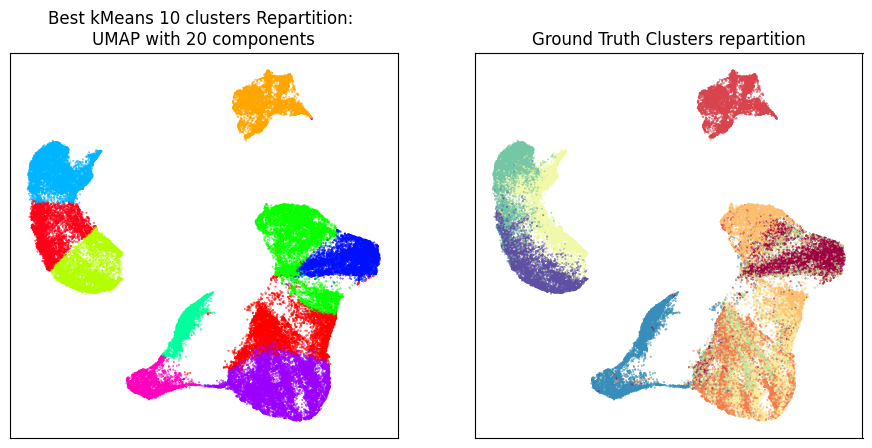

In [162]:
X_umap_2 = pd.read_csv(DATA_FOLDER / 'X_umap_2.csv')

best_kmeans_labels = KMeans(n_clusters=10, random_state=42).fit_predict( pd.read_csv(DATA_FOLDER / 'X_umap_20.csv') )

fig = plt.figure(figsize=(11, 5))
best_kmeans_ax = fig.add_subplot(121)

best_kmeans_ax.scatter(
    X_umap_2['Component_0']
    , X_umap_2['Component_1']
    , c=best_kmeans_labels.astype(np.int32)
    , cmap='hsv'
    , s=0.1
)
best_kmeans_ax.set_title('Best kMeans 10 clusters Repartition: \nUMAP with 20 components')
best_kmeans_ax.set(xticks=[], yticks=[])

original_ax = fig.add_subplot(122)
original_ax.scatter(
    X_umap_2['Component_0']
    , X_umap_2['Component_1']
    , c=y_train.astype(np.int32)
    , cmap='Spectral'
    , s=0.1
)
original_ax.set_title('Ground Truth Clusters repartition')
original_ax.set(xticks=[], yticks=[])

plt.show()

While K-Means gets some cases correct, such as the cluster on the top right side, most of the rest of the data looks somewhat arbitrarily carved up among the remaining clusters. 